<a href="https://colab.research.google.com/github/Chia-Yin-Lee/NTHU/blob/main/LSTM_Fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title show your CPU or GPU details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1643909835390971313
 xla_global_id: -1]

In [ ]:
#@title connect google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/thesis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/thesis


In [ ]:
#@title Import packages

import math
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
sector = 'industrial'
df = pd.read_csv(f"{sector}_df.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (5751, 24)


,Date,Symbol,Open,Close,Low,High,Volume,VolumeChangeAmount,VolumeChangeRate,MACD,...,EMA20,MA5,MA10,V_MA5,V_MA10,MTM6,MTM12,ROC,SMI,WVAD
0,2021-04-26,O5RU.SI,1.146708,1.163448,1.138337,1.163448,472300,0.0,0.000000,0.000000,...,1.163448,1.163448,1.163448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-27,O5RU.SI,1.163448,1.146708,1.146708,1.163448,312800,-159500.0,-33.770908,-0.000376,...,1.154659,1.153404,1.154241,NaN,NaN,NaN,NaN,NaN,NaN,-1.042657e+05
2,2021-04-28,O5RU.SI,1.155078,1.155078,1.146708,1.163448,283400,-29400.0,-9.398977,-0.000219,...,1.154813,1.154197,1.154577,NaN,NaN,NaN,NaN,NaN,NaN,1.361340e+00
3,2021-04-29,O5RU.SI,1.155078,1.163448,1.146708,1.163448,399700,116300.0,41.037403,0.000160,...,1.157306,1.158040,1.157500,NaN,NaN,NaN,NaN,NaN,NaN,3.996962e+05
4,2021-04-30,O5RU.SI,1.155078,1.171818,1.155078,1.180188,1026100,626400.0,156.717538,0.000695,...,1.160816,1.163329,1.161610,498860.0,NaN,NaN,NaN,NaN,NaN,2.052234e+06


In [ ]:
#@title separate_df_by_column & inf_nan_replace function

def separate_df_by_column(df, column_name = 'Symbol'):
  # Group the DataFrame by the specified column
  grouped = df.groupby(column_name)

  # Initialize an empty dictionary to store the resulting DataFrames
  result_dict = {}

  # Iterate through the groups and create separate DataFrames
  for group_name, group_df in grouped:
      group_df = inf_nan_replace(group_df)
      result_dict[f'{group_name}_df'] = group_df

  return result_dict

def inf_nan_replace(df):
  # Identify and Replace 'inf' Values
  df.replace([np.inf, -np.inf], np.nan, inplace=True)

  # Interpolation
  missing_cols = df.columns[df.isna().any()].tolist()
  df[missing_cols] = df[missing_cols].interpolate(method='linear', axis=0)

  return df

separate_df_dict = separate_df_by_column(df)
for group_name, group_df in separate_df_dict.items():
    print(f"Group: {group_name}")
    print(group_df)

Group: A17U.SI_df
            Date   Symbol      Open     Close       Low      High    Volume  \
590   2021-04-26  A17U.SI  2.726785  2.726785  2.700566  2.744265  10907000   
591   2021-04-27  A17U.SI  2.735526  2.718046  2.709306  2.744265   7298500   
592   2021-04-28  A17U.SI  2.700566  2.744265  2.691827  2.744265  10837500   
593   2021-04-29  A17U.SI  2.753005  2.744265  2.735525  2.753005   5942000   
594   2021-04-30  A17U.SI  2.726786  2.718046  2.709306  2.735526   9580200   
...          ...      ...       ...       ...       ...       ...       ...   
1175  2023-08-24  A17U.SI  2.710000  2.720000  2.710000  2.740000  11325100   
1176  2023-08-25  A17U.SI  2.720000  2.750000  2.700000  2.760000   7259000   
1177  2023-08-28  A17U.SI  2.750000  2.750000  2.720000  2.770000  12227600   
1178  2023-08-29  A17U.SI  2.740000  2.760000  2.740000  2.780000  10214500   
1179  2023-08-30  A17U.SI  2.780000  2.790000  2.770000  2.800000  11223200   

      VolumeChangeAmount  VolumeC

In [ ]:
macro_df = pd.read_csv("macroeconomic_df.csv", index_col = False)
print('Number of rows and columns:', macro_df.shape)
macro_df.head(5)

Number of rows and columns: (353, 6)


,Date,FX,DFF,VIX,SIBOR_1M,SIBOR_3M
0,2022-04-26,1.37369,0.833,33.520000,0.67214,1.05606
1,2022-04-27,1.37781,0.808,31.600000,0.67500,1.05624
2,2022-04-28,1.38077,0.785,29.990000,0.67518,1.05679
3,2022-04-29,1.38650,0.808,33.400002,0.78554,1.09375
4,2022-05-02,1.38370,0.765,32.340000,0.78554,1.09375


In [ ]:
#@title Merge price and macroeconomic function

def merge_price_macro(df1, df2, col_name = 'Date', threshold = '2022-04-26'):

  # Merge the DataFrames on the 'Date' column
  merged_df = pd.merge(df1, df2, on=col_name, how = 'left')

  cut_df = merged_df[merged_df[col_name] >= threshold]

  return cut_df

for group_name, group_df in separate_df_dict.items():
    group_df1 = merge_price_macro(group_df, macro_df)
    print(group_df1.describe())  # make sure there's no NaN nor inf

    group_df1.to_csv(f"{group_name}.csv", index = False)  # save the merged data into csv (per reit)

             Open       Close         Low        High        Volume  \
count  337.000000  337.000000  337.000000  337.000000  3.370000e+02   
mean     2.661373    2.660364    2.639113    2.682702  1.128737e+07   
std      0.101374    0.102694    0.102428    0.098679  4.852854e+06   
min      2.355281    2.336363    2.317445    2.374199  0.000000e+00   
25%      2.597657    2.591755    2.570022    2.616080  8.129500e+06   
50%      2.676885    2.676885    2.662138    2.695803  1.034920e+07   
75%      2.733639    2.735830    2.714721    2.752557  1.351820e+07   
max      2.839616    2.849341    2.809311    2.849341  4.389450e+07   

       VolumeChangeAmount  VolumeChangeRate        MACD         CCI  \
count        3.370000e+02        337.000000  337.000000  337.000000   
mean        -1.184243e+04         10.114030    0.001704    4.549951   
std          6.019830e+06         55.719408    0.025219   66.610122   
min         -2.245390e+07       -100.000000   -0.064152  -66.666667   
25%  

## LSTM


In [ ]:
reitname = []
for group_name, group_df in separate_df_dict.items():
  reitname.append(group_name[:-6])

print(reitname)

['A17U', 'AJBU', 'BUOU', 'BWCU', 'DHLU', 'J91U', 'M1GU', 'M44U', 'ME8U', 'O5RU']


In [ ]:
col_list = ['Date', 'Close', 'Open', 'Low', 'High',	'Volume',	'VolumeChangeAmount',
            'VolumeChangeRate',	'MACD',	'CCI', 'ATR', 'BOLL_U', 'BOLL_L', 'EMA20',
            'MA5',	'MA10',	'V_MA5', 'V_MA10',	'MTM6', 'MTM12',	'ROC',	'SMI',
            'WVAD',	'FX',	'DFF',	'VIX',	'SIBOR_1M',	'SIBOR_3M']

In [ ]:
#@title Load multiple data function

def load_data(reitname_list, col_list):
  datasets = []

  for reit in reitname_list:

      file_name = f'{reit}.SI_df.csv'
      df = pd.read_csv(file_name)
      df = df[col_list]
      df.set_index('Date', drop=True, inplace=True)
      print(file_name)
      print(df.iloc[:5,:])
      df_name = f'{reit}_df'

      # We add a prediction column and set dummy values to prepare the data for scaling
      df_ext = df.copy()
      df_ext['Prediction'] = df_ext['Close']
      datasets.append((df_name, df_ext))

  return datasets

datasets = load_data(reitname, col_list)

In [ ]:
#@title partition_dataset function
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
#@title Training function
def Train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 16):
  # Configure the neural network model
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])

  # An LSTM layer, which takes our mini-batches as input and returns the whole sequence
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
  # Another LSTM layer that takes the sequence from the previous layer but only returns five values
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Training the model
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test)
                    )

                      #callbacks=[early_stop])

  return model, history

In [ ]:
#@title Prediction function

def Predict(model, scaler_pred, x_test, y_test):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  # Root Mean Square Error (RMSE)
  RMSE = np.sqrt(np.mean(np.square(np.subtract(y_test_unscaled, y_pred))))
  print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)} %')

  # R-squared (R^2)
  R2 = 1 - (np.sum(np.square(np.subtract(y_test_unscaled, y_pred))) / np.sum(np.square(np.subtract(np.mean(y_test_unscaled), y_test_unscaled))))
  print(f'R-squared (R^2): {np.round(R2, 2)} %')

  return y_pred, y_test_unscaled, MAE, MAPE, MDAPE, RMSE, R2

In [ ]:
#@title Scaling the Multivariate Input Data function

# The date from which on the date is displayed
start_date = "2022-04-26"
end_date = "2023-08-31"
MAE_dict = defaultdict(int)
MAPE_dict = defaultdict(int)
MDAPE_dict = defaultdict(int)
RMSE_dict = defaultdict(int)
R2_dict = defaultdict(int)

def a():
    return []
datasets_zoom = defaultdict(a)

nrows = datasets[0][1].shape[0]  # All the df.shape() should be the same!!

for dataset_name, df in datasets:

  # Convert the data to numpy values
  np_data_unscaled = np.array(df)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print('The size of', dataset_name, 'is', np_data.shape)

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(df['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # Set the sequence length - this is the timeframe used to make a single prediction
  sequence_length = 7

  # Prediction Index
  index_Close = df.columns.get_loc("Close")

  # Split the training data into train and train data sets
  # As a first step, we get the number of rows to train the model on 80% of the data
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

  # Create the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data)
  x_test, y_test = partition_dataset(sequence_length, test_data)

  # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
  print(x_train.shape, y_train.shape)
  print(x_test.shape, y_test.shape)

  # Validate that the prediction value and the input match up
  # The last close price of the second input sample should equal the first prediction value
  print(x_train[1][sequence_length-1][index_Close])
  print(y_train[0])

  # Train!
  model, history = Train(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 16)

  # Predict!
  y_pred, y_test_unscaled, MAE, MAPE, MDAPE, RMSE, R2 = Predict(model, scaler_pred, x_test, y_test)

  MAE_dict[dataset_name] = MAE
  MAPE_dict[dataset_name] = MAPE
  MDAPE_dict[dataset_name] = MDAPE
  RMSE_dict[dataset_name] = RMSE
  R2_dict[dataset_name] = R2

  # Add the difference between the valid and predicted prices
  train = pd.DataFrame(df['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  valid = pd.DataFrame(df['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
  valid.insert(1, "y_pred", y_pred, True)
  valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)

  df_union = pd.concat([train, valid])

  # Zoom in to a closer timeframe
  df_union_zoom = df_union[df_union.index > start_date]
  datasets_zoom[dataset_name] = df_union_zoom

The size of A17U_df is (337, 28)
(263, 7, 28) (263,)
(67, 7, 28) (67,)
0.45549629691599414
0.45549629691599414
196 7 28
Epoch 1/50
17/17 [==============================] - 7s 103ms/step - loss: 0.0362 - val_loss: 0.0082
Epoch 2/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 3/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 4/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 5/50
17/17 [==============================] - 1s 43ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 6/50
17/17 [==============================] - 1s 41ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 7/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0055 - val_loss: 0.0085
Epoch 8/50
17/17 [==============================] - 1s 44ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 9/50
17/17 [==============================] - 1s 48ms/step - loss: 0.0053 - val_l

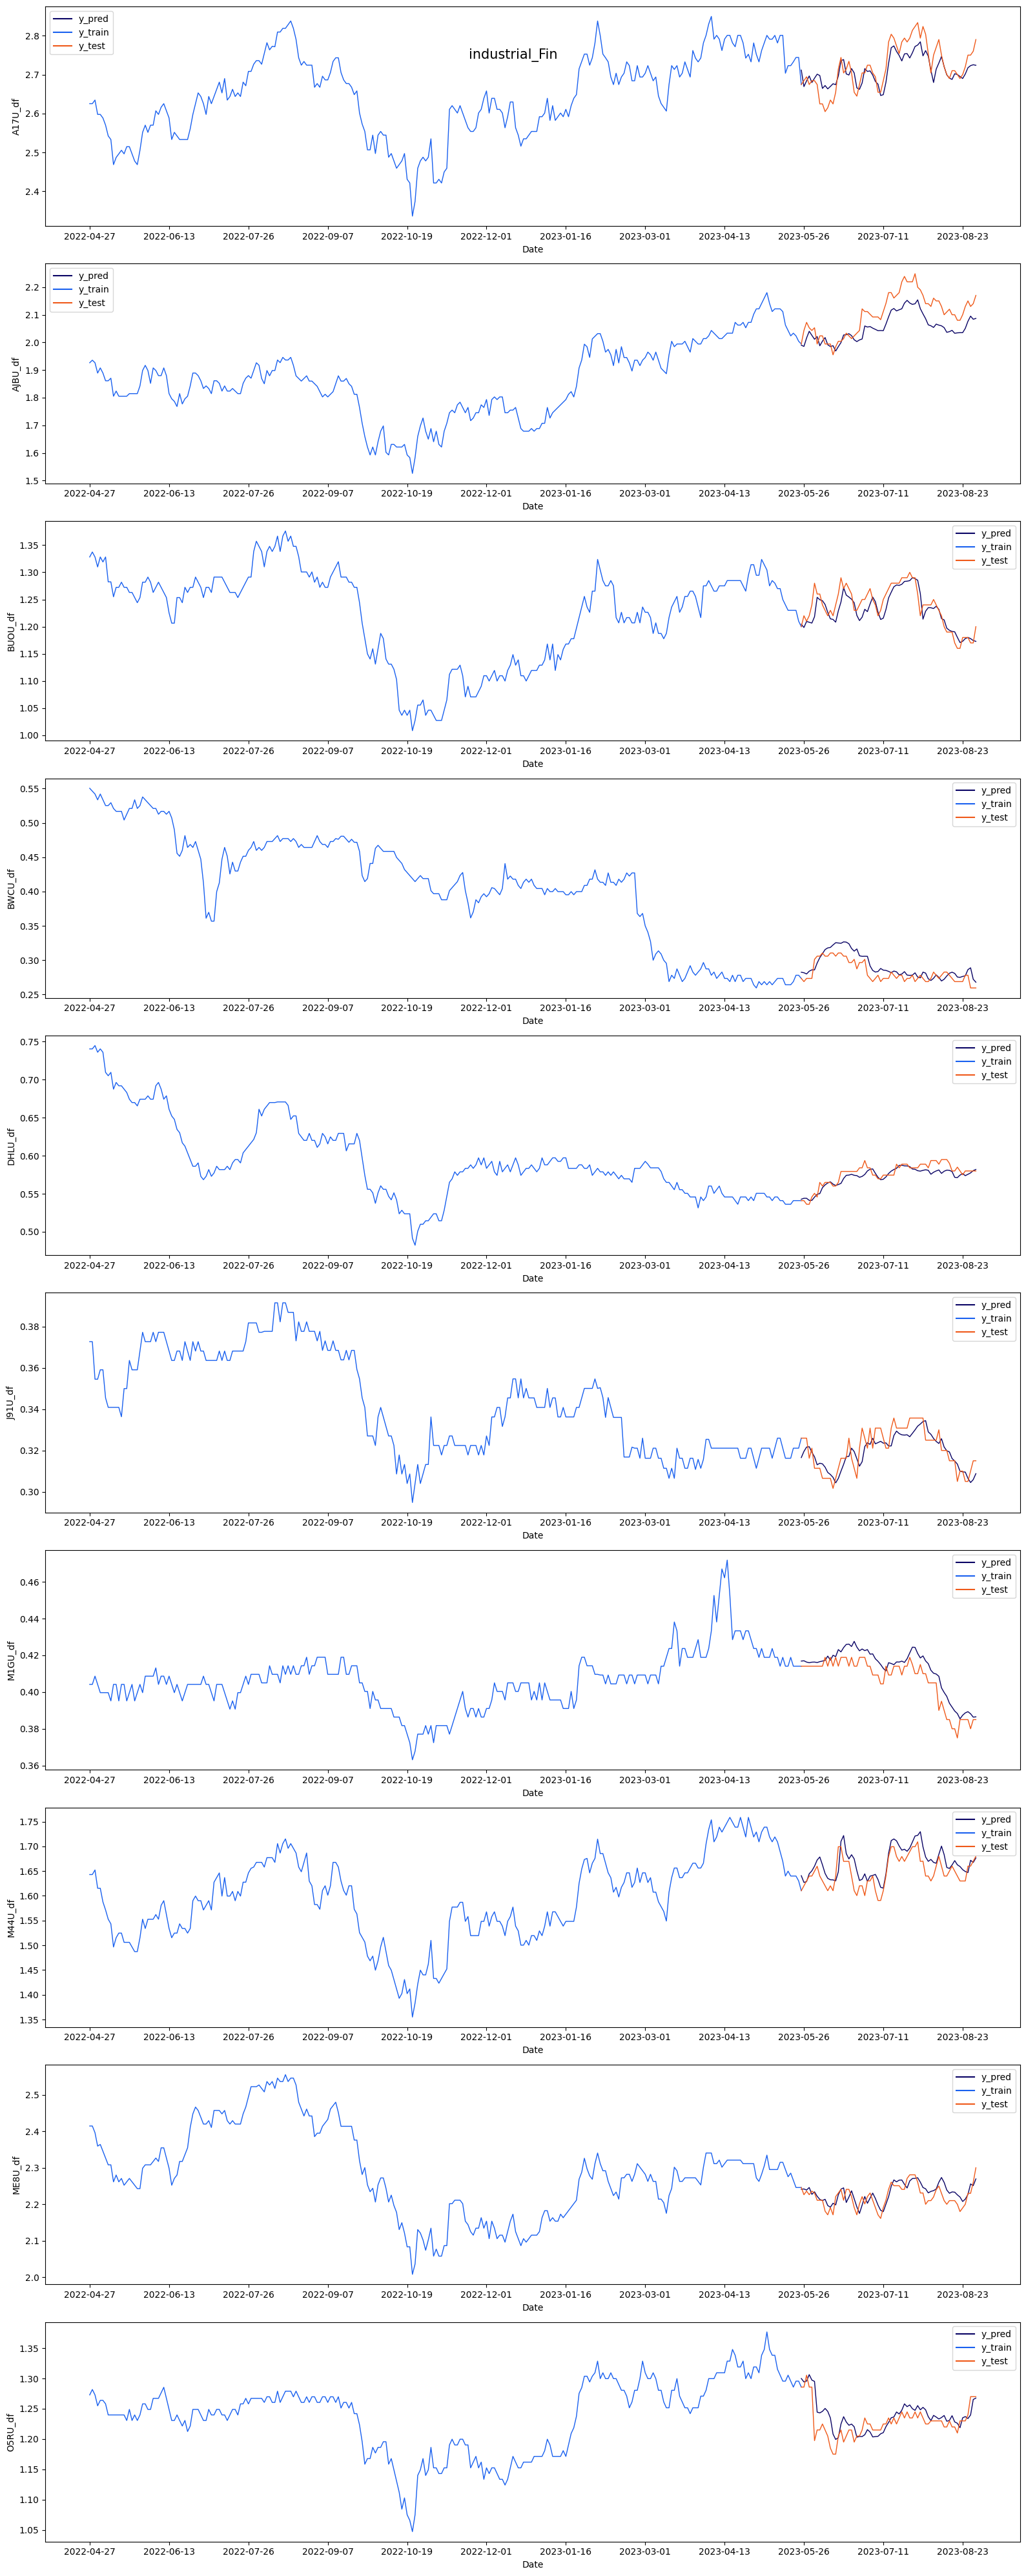

In [ ]:
#@title Create the lineplot

fig, axes = plt.subplots(len(reitname), 1, figsize=(16, len(reitname)*4))
#sector = 'hospitality'

i = 0
for dataset_name, df_union_zoom in datasets_zoom.items():
  axes[i].set_xticks(np.arange(0, nrows, 30))
  axes[i].set_ylabel(dataset_name, fontsize = 10)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=axes[i])
  i += 1
  # Create the bar plot with the differences
  #df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  #axes[0].bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
  plt.legend()

plt.tight_layout()
plt.suptitle(f"{sector}_Fin", fontsize = 15)
plt.savefig(f'{sector}_7ts.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
#@title show Metrics

metric_dict = {}
for d in [MAE_dict, MAPE_dict, MDAPE_dict, RMSE_dict, R2_dict]:
    for key, value in d.items():
        if key in metric_dict:
            metric_dict[key].append(value)
        else:
            metric_dict[key] = [value]

metric_df = pd.DataFrame(metric_dict)
metric_df.index = ['MAE', 'MAPE', 'MDAPE', 'RMSE', 'R2']
metric_df.to_csv(f"{sector}_metrics.csv")

## single REIT

In [ ]:
file_name = 'ACV.SI_df.csv'
df = pd.read_csv(file_name)
df = df[col_list]
df.set_index('Date', drop=True, inplace=True)

# We add a prediction column and set dummy values to prepare the data for scaling
df_ext = df.copy()
df_ext['Prediction'] = df_ext['Close']

In [ ]:
df_ext.head()

,Close,Open,Low,High,Volume,VolumeChangeAmount,VolumeChangeRate,MACD,CCI,ATR,...,MTM12,ROC,SMI,WVAD,FX,DFF,VIX,SIBOR_1M,SIBOR_3M,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-26,1.050615,1.041400,1.032184,1.059831,18209300,12231000.0,204.589934,0.013093,66.666667,0.021723,...,0.132298,1.785719,-3.968236,1.820937e+07,1.37369,0.833,33.520000,0.67214,1.05606,1.050615
2022-04-27,1.050615,1.041400,1.041400,1.059831,15087500,-3121800.0,-17.143987,0.013581,66.666667,0.021723,...,0.121616,2.702699,0.793673,5.029167e+06,1.37781,0.808,31.600000,0.67500,1.05624,1.050615
2022-04-28,1.059831,1.050615,1.050615,1.069047,6132500,-8955000.0,-59.353770,0.014545,66.666667,0.021723,...,0.120880,4.545443,1.190482,6.132523e+06,1.38077,0.785,29.990000,0.67518,1.05679,1.059831
2022-04-29,1.069047,1.069047,1.059831,1.087479,16125400,9992900.0,162.949857,0.015869,66.666667,0.022382,...,0.141293,6.422012,-4.404755,1.612546e+07,1.38650,0.808,33.400002,0.78554,1.09375,1.069047
2022-05-04,1.069047,1.059831,1.050615,1.087479,19196500,3071100.0,19.045109,0.016725,66.666667,0.023698,...,0.163241,6.422012,-2.499998,-6.398833e+06,1.38384,0.833,25.420000,0.78691,1.11250,1.069047


In [ ]:
# Get the number of rows in the data
nrows = df.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(df)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1348, 27)


In [ ]:
train_days = int(np_data.shape[0] * 0.9)
train_data_len

1079

In [ ]:
len(train_data)

1079

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = df.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1072, 7, 27) (1072,)
(269, 7, 27) (269,)
0.7302929413573689
0.7302929413573689


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

189 7 27


In [ ]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

                    #callbacks=[early_stop])

Epoch 1/50
67/67 [==============================] - 9s 62ms/step - loss: 0.0196 - val_loss: 9.3614e-04
Epoch 2/50
67/67 [==============================] - 6s 84ms/step - loss: 0.0018 - val_loss: 7.6969e-04
Epoch 3/50
67/67 [==============================] - 6s 88ms/step - loss: 0.0018 - val_loss: 6.8785e-04
Epoch 4/50
67/67 [==============================] - 4s 59ms/step - loss: 0.0016 - val_loss: 6.6143e-04
Epoch 5/50
67/67 [==============================] - 5s 81ms/step - loss: 0.0014 - val_loss: 7.6798e-04
Epoch 6/50
67/67 [==============================] - 4s 62ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 7/50
67/67 [==============================] - 2s 34ms/step - loss: 0.0014 - val_loss: 8.5597e-04
Epoch 8/50
67/67 [==============================] - 2s 36ms/step - loss: 0.0013 - val_loss: 8.2343e-04
Epoch 9/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/50
67/67 [==============================] - 3s 39ms/step - loss: 0.0011 

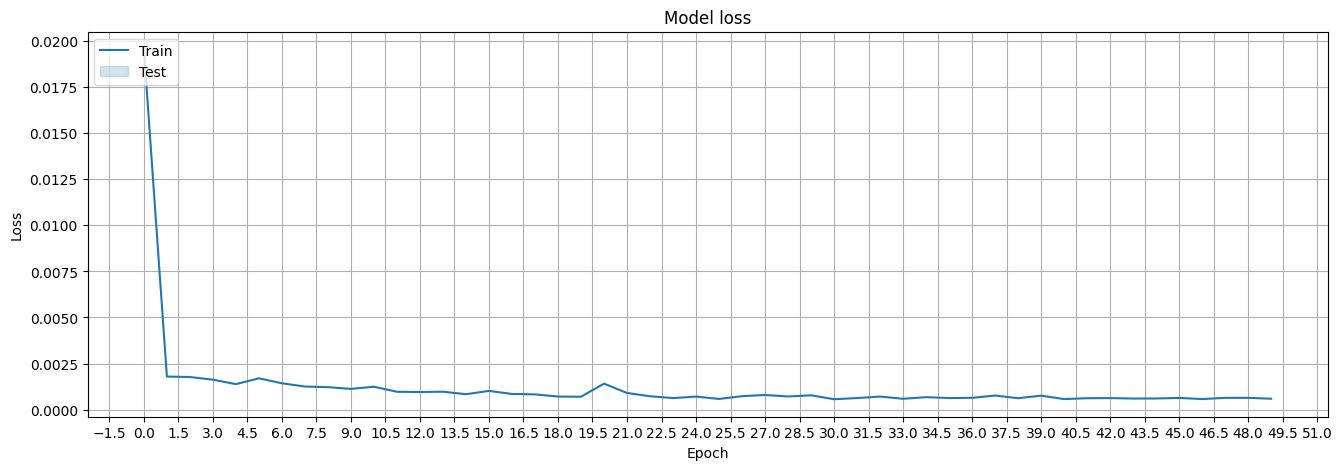

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# Root Mean Square Error (RMSE)
RMSE = np.sqrt(np.mean(np.square(np.subtract(y_test_unscaled, y_pred))))
print(f'Root Mean Square Error (RMSE): {np.round(RMSE, 2)} %')

# R-squared (R^2)
R2 = 1 - (np.sum(np.square(np.subtract(y_test_unscaled, y_pred))) / np.sum(np.square(np.subtract(np.mean(y_test_unscaled), y_test_unscaled))))
print(f'R-squared (R^2): {np.round(R2, 2)} %')

9/9 [==============================] - 1s 38ms/step
Median Absolute Error (MAE): 0.02
Mean Absolute Percentage Error (MAPE): 4.06 %
Median Absolute Percentage Error (MDAPE): 3.6 %
Root Mean Square Error (RMSE): 0.02 %
R-squared (R^2): 0.87 %


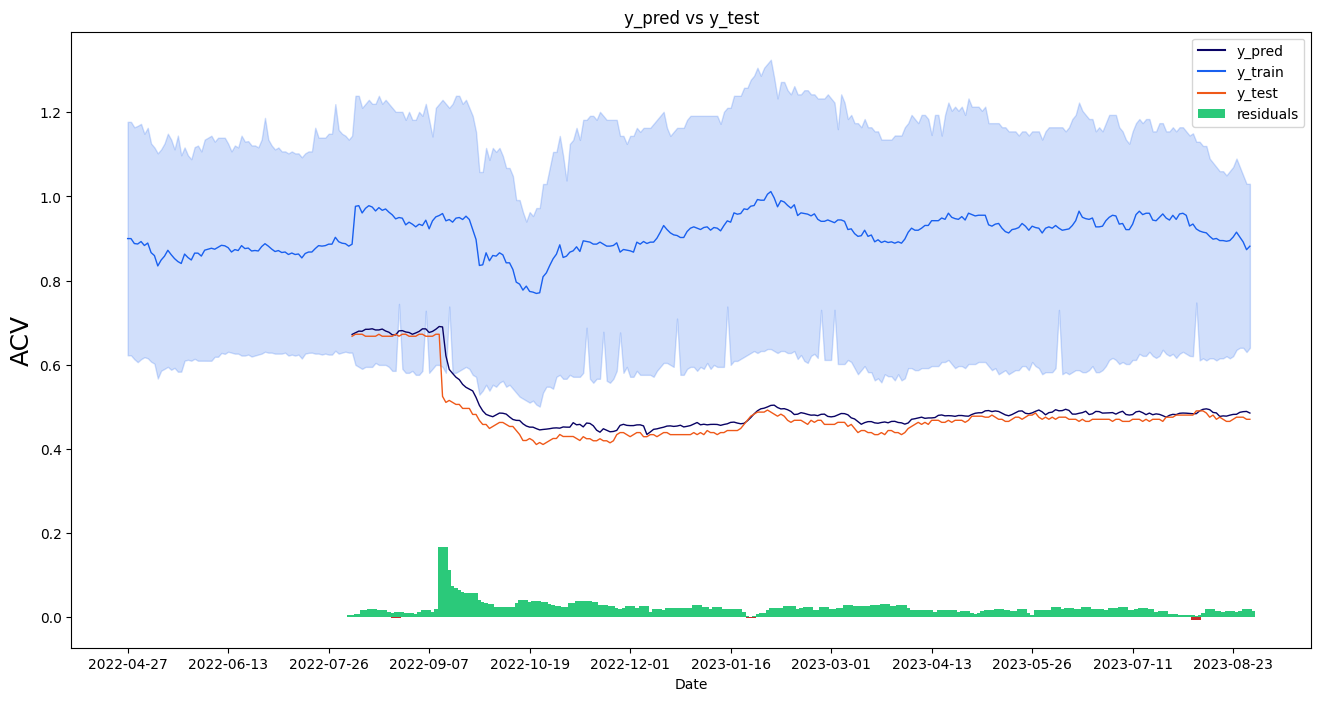

In [ ]:
# The date from which on the date is displayed
display_start_date = "2022-04-26"
end_date = "2023-08-31"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.xticks(np.arange(0, nrows, 30))
plt.ylabel('ACV', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.savefig('AVC_7ts.png')  # Save the plot as a PNG file

plt.show()

In [ ]:
#@title Predict the Next Day’s Price

df_temp = df[-sequence_length:]
new_df = df_temp.filter(col_list)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {reitname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 29ms/step
The close price for AW9U at 2023-08-31 was 0.25
The predicted close price is 0.25 (0.0%)


In [ ]:
#@title input close price only; build the input features with time lag of 1 day (lag 1)

size_of_train = 300
training_close = df.iloc[:size_of_train, 3:4].values
test_close = df.iloc[size_of_train:, 3:4].values

# Feature Scaling
# To normalize the data before model fitting
sc = MinMaxScaler(feature_range = (0, 1))
training_close_scaled = sc.fit_transform(training_close)


In [ ]:
#@title Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
time_steps = 60

for i in range(time_steps, size_of_train):
    X_train.append(training_close_scaled[i-time_steps:i, 0])
    y_train.append(training_close_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # (#values, #time-steps, #1 dimensional output) = (240, 60, 1)

In [ ]:
#@title build a LSTM model

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
#@title prepare the test data and reshape

# Getting the predicted stock price
dataset_train = df.iloc[:size_of_train, 3:4]
dataset_test = df.iloc[size_of_train:, 3:4]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values
len_input = len(inputs)

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len_input):
    X_test.append(inputs[i-time_steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)  # (37, 60, 1)

(37, 60, 1)


In [ ]:
#@title Make Predictions using the test set

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 [==============================] - 1s 14ms/step


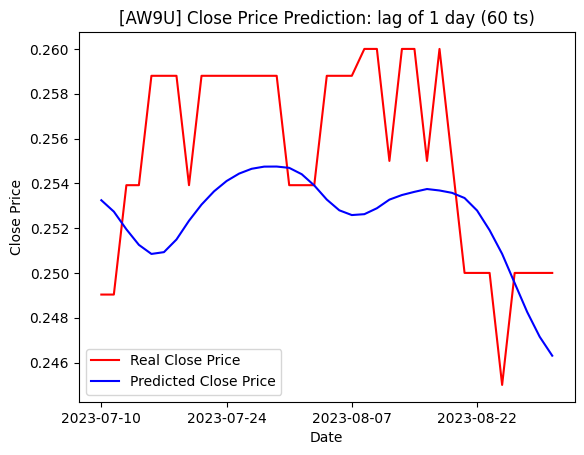

In [ ]:
#@title Visualising the results

plt.plot(df.loc[size_of_train:, 'Date'], dataset_test.values, color = 'red', label = 'Real Close Price')
plt.plot(df.loc[size_of_train:, 'Date'], predicted_stock_price, color = 'blue', label = 'Predicted Close Price')
plt.xticks(np.arange(0, 37, 10))
plt.title('[AW9U] Close Price Prediction: lag of 1 day (60 ts)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('AW9U_close_1d_60ts.png')  # Save the plot as a PNG file

plt.show()